In [1]:
import scipy.stats as stats
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
# Set display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
data = pd.read_csv(r"C:\Users\ashka\OneDrive\Documents\DA 205 Segmentation\final version.csv")
data.head()

user_id  age gender  married  has_children  total_sessions  \
0    23557   64      F        1             0               8   
1    94883   51      F        1             0               8   
2   101486   50      F        1             1               8   
3   101961   42      F        1             0               8   
4   106907   44      F        1             1               8   

   total_page_clicks  avg_page_clicks_per_session  discount_flight_proportion  \
0                 82                       10.250                       0.000   
1                 73                        9.125                       0.000   
2                131                       16.375                       0.250   
3                126                       15.750                       0.250   
4                240                       30.000                       0.125   

   mean_session_time  total_flights_booked  total_hotels_booked  \
0          76.625000                     0                    2   
1          67.750000                     2                    2   
2         122.250000                     1                    2   
3         117.750000                     5                    5   
4         758.915066                     2                    2   

   total_cancellations  avg_flight_discount  avg_hotel_discount  \
0                    0                0.000               0.250   
1                    0                0.000               0.125   
2                    0                0.250               0.000   
3                    0                0.250               0.125   
4                    1                0.125               0.125   

   total_checked_bags  percentage_flights_with_checked_bags  \
0                 NaN                                   0.0   
1                 1.0                                  50.0   
2                 0.0                                   0.0   
3                 2.0                                  40.0   
4                10.0                                 500.0   

   avg_base_fare_usd  avg_hotel_per_room_usd  scaled_ads_per_km  \
0                NaN                   177.0                NaN   
1            432.045                    90.0                NaN   
2            189.910                   198.5                NaN   
3            248.532                   136.0           0.000727   
4          13902.060                   129.0                NaN   

   days_since_last_session  
0                      -14  
1                        0  
2                      -10  
3                       -6  
4                       -1

### Most of these features have been engineered. Let's clean the data and prepare it for segmentation. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 21 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   user_id                               5998 non-null   int64  
 1   age                                   5998 non-null   int64  
 2   gender                                5998 non-null   object 
 3   married                               5998 non-null   int64  
 4   has_children                          5998 non-null   int64  
 5   total_sessions                        5998 non-null   int64  
 6   total_page_clicks                     5998 non-null   int64  
 7   avg_page_clicks_per_session           5998 non-null   float64
 8   discount_flight_proportion            5998 non-null   float64
 9   mean_session_time                     5998 non-null   float64
 10  total_flights_booked                  5998 non-null   int64  
 11  total_hotels_book

In [4]:
data.isna().sum() 

user_id                                    0
age                                        0
gender                                     0
married                                    0
has_children                               0
total_sessions                             0
total_page_clicks                          0
avg_page_clicks_per_session                0
discount_flight_proportion                 0
mean_session_time                          0
total_flights_booked                       0
total_hotels_booked                        0
total_cancellations                        0
avg_flight_discount                        0
avg_hotel_discount                         0
total_checked_bags                       818
percentage_flights_with_checked_bags      11
avg_base_fare_usd                        818
avg_hotel_per_room_usd                   596
scaled_ads_per_km                       4280
days_since_last_session                    0
dtype: int64

In [5]:
summary_stats = data.describe()
print(summary_stats)

             user_id          age      married  has_children  total_sessions  \
count    5998.000000  5998.000000  5998.000000   5998.000000     5998.000000   
mean   545440.695565    40.967156     0.440480      0.326442        8.204568   
std     64924.749760    12.046202     0.496486      0.468950        0.460911   
min     23557.000000    16.000000     0.000000      0.000000        8.000000   
25%    517152.000000    34.000000     0.000000      0.000000        8.000000   
50%    540542.000000    41.000000     0.000000      0.000000        8.000000   
75%    574146.000000    48.000000     1.000000      1.000000        8.000000   
max    844489.000000    88.000000     1.000000      1.000000       12.000000   

       total_page_clicks  avg_page_clicks_per_session  \
count        5998.000000                  5998.000000   
mean          144.308436                    17.586393   
std            72.330165                     8.735165   
min            33.000000                     4.1250

In [6]:
# Filling Missing Values for Columns

# Fill missing values with 0 for columns indicating absence
columns_to_fill_with_zero = [
    'total_checked_bags',
    'percentage_flights_with_checked_bags',
    'avg_base_fare_usd',
    'avg_hotel_per_room_usd',
    'scaled_ads_per_km'
]

data[columns_to_fill_with_zero] = data[columns_to_fill_with_zero].fillna(0)

# Calculate the 'bargain_hunter_index'
data['bargain_hunter_index'] = (
    data['scaled_ads_per_km'] * 
    data['discount_flight_proportion'] * 
    data['avg_flight_discount']
)

# Display the updated information about missing values after filling
missing_values_after_filling = data.isnull().sum()
print("Missing Values After Filling:")
print(missing_values_after_filling)


Missing Values After Filling:
user_id                                 0
age                                     0
gender                                  0
married                                 0
has_children                            0
total_sessions                          0
total_page_clicks                       0
avg_page_clicks_per_session             0
discount_flight_proportion              0
mean_session_time                       0
total_flights_booked                    0
total_hotels_booked                     0
total_cancellations                     0
avg_flight_discount                     0
avg_hotel_discount                      0
total_checked_bags                      0
percentage_flights_with_checked_bags    0
avg_base_fare_usd                       0
avg_hotel_per_room_usd                  0
scaled_ads_per_km                       0
days_since_last_session                 0
bargain_hunter_index                    0
dtype: int64


In [7]:
# Select the relevant columns for scaling
columns_to_scale = ['age', 'total_sessions', 'total_page_clicks', 'avg_page_clicks_per_session',
                    'discount_flight_proportion', 'mean_session_time', 'total_flights_booked',
                    'total_hotels_booked', 'total_cancellations', 'avg_flight_discount',
                    'avg_hotel_discount', 'total_checked_bags', 'percentage_flights_with_checked_bags',
                    'avg_base_fare_usd', 'avg_hotel_per_room_usd', 'scaled_ads_per_km',
                    'days_since_last_session', 'bargain_hunter_index']

# Initialize the scaler
scaler = StandardScaler()

# Scale the selected columns
data_scaled = scaler.fit_transform(data[columns_to_scale])

# Create a new DataFrame with the scaled features
scaled_df = pd.DataFrame(data_scaled, columns=columns_to_scale)

# Display the first few rows of the scaled DataFrame
print(scaled_df.head())

        age  total_sessions  total_page_clicks  avg_page_clicks_per_session  \
0  1.912201       -0.443872          -0.861517                    -0.839939   
1  0.832933       -0.443872          -0.985956                    -0.968739   
2  0.749913       -0.443872          -0.184011                    -0.138692   
3  0.085747       -0.443872          -0.253144                    -0.210247   
4  0.251789       -0.443872           1.323093                     1.421226   

   discount_flight_proportion  mean_session_time  total_flights_booked  \
0                   -1.346678          -0.458165             -1.527351   
1                   -1.346678          -0.494984             -0.247875   
2                    0.517562          -0.268879             -0.887613   
3                    0.517562          -0.287549              1.671340   
4                   -0.414558           2.372462             -0.247875   

   total_hotels_booked  total_cancellations  avg_flight_discount  \
0           

In [8]:
# Perform one-hot encoding for the 'gender' column
gender_encoded = pd.get_dummies(data['gender'], prefix='gender', drop_first=True)

# Concatenate the one-hot encoded 'gender' columns with the scaled DataFrame
final_data = pd.concat([scaled_df, gender_encoded], axis=1)

# Display the first few rows of the final preprocessed DataFrame
final_data.head()

age  total_sessions  total_page_clicks  avg_page_clicks_per_session  \
0  1.912201       -0.443872          -0.861517                    -0.839939   
1  0.832933       -0.443872          -0.985956                    -0.968739   
2  0.749913       -0.443872          -0.184011                    -0.138692   
3  0.085747       -0.443872          -0.253144                    -0.210247   
4  0.251789       -0.443872           1.323093                     1.421226   

   discount_flight_proportion  mean_session_time  total_flights_booked  \
0                   -1.346678          -0.458165             -1.527351   
1                   -1.346678          -0.494984             -0.247875   
2                    0.517562          -0.268879             -0.887613   
3                    0.517562          -0.287549              1.671340   
4                   -0.414558           2.372462             -0.247875   

   total_hotels_booked  total_cancellations  avg_flight_discount  \
0            -0.325163            -0.327625            -1.346678   
1            -0.325163            -0.327625            -1.346678   
2            -0.325163            -0.327625             0.517562   
3             1.676541            -0.327625             0.517562   
4            -0.325163             2.893840            -0.414558   

   avg_hotel_discount  total_checked_bags  \
0            0.917107           -0.974834   
1           -0.110373           -0.283774   
2           -1.137852           -0.974834   
3           -0.110373            0.407285   
4           -0.110373            5.935759   

   percentage_flights_with_checked_bags  avg_base_fare_usd  \
0                             -1.002442          -0.664949   
1                             -0.032264          -0.045374   
2                             -1.002442          -0.392608   
3                             -0.226300          -0.308541   
4                              8.699336          19.271337   

   avg_hotel_per_room_usd  scaled_ads_per_km  days_since_last_session  \
0                0.171941          -0.383359                 0.076979   
1               -0.732621          -0.383359                 1.784354   
2                0.395482          -0.383359                 0.564801   
3               -0.254347          -0.306286                 1.052622   
4               -0.327128          -0.383359                 1.662399   

   bargain_hunter_index  gender_M  gender_O  
0             -0.254131     False     False  
1             -0.254131     False     False  
2             -0.254131     False     False  
3             -0.219304     False     False  
4             -0.254131     False     False

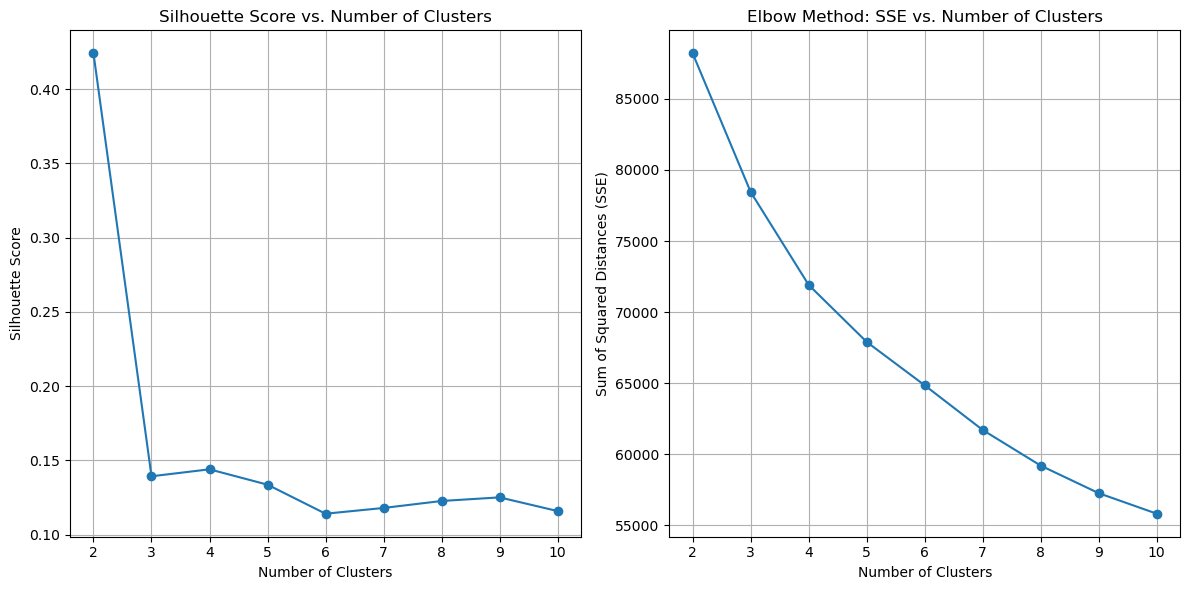

Number of Clusters: 2
Silhouette Score: 0.42411707571207086
SSE: 88205.73313924103

Number of Clusters: 3
Silhouette Score: 0.13928798336292456
SSE: 78447.3158715672

Number of Clusters: 4
Silhouette Score: 0.14396854224745462
SSE: 71908.32744371408

Number of Clusters: 5
Silhouette Score: 0.1336224582604475
SSE: 67897.1076904402

Number of Clusters: 6
Silhouette Score: 0.11407592835638257
SSE: 64843.78569182226

Number of Clusters: 7
Silhouette Score: 0.1179417875367208
SSE: 61699.940317919194

Number of Clusters: 8
Silhouette Score: 0.12264344440544991
SSE: 59191.74527957958

Number of Clusters: 9
Silhouette Score: 0.12507452882884174
SSE: 57253.57967001053

Number of Clusters: 10
Silhouette Score: 0.11585519705743348
SSE: 55810.895060112336



In [9]:
# Select the range of cluster numbers to try
num_clusters_range = range(2, 11)

# Initialize lists to store silhouette scores, sum of squared distances, and KMeans models
silhouette_scores = []
sse_scores = []
kmeans_models = []

# Loop through the range of cluster numbers and fit KMeans models
for num_clusters in num_clusters_range:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=0)
    kmeans.fit(final_data)
    kmeans_models.append(kmeans)
    
    # Calculate the silhouette score for the current model
    silhouette_scores.append(silhouette_score(final_data, kmeans.labels_))
    
    # Calculate the sum of squared distances (SSE) for the current model
    sse_scores.append(kmeans.inertia_)

# Plot the silhouette scores and SSE to help determine the optimal number of clusters
plt.figure(figsize=(12, 6))

# Plot silhouette scores
plt.subplot(1, 2, 1)
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')
plt.grid()

# Plot SSE
plt.subplot(1, 2, 2)
plt.plot(num_clusters_range, sse_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances (SSE)')
plt.title('Elbow Method: SSE vs. Number of Clusters')
plt.grid()

plt.tight_layout()
plt.show()

# Print silhouette scores and SSE for each cluster number
for i, num_clusters in enumerate(num_clusters_range):
    print(f"Number of Clusters: {num_clusters}")
    print(f"Silhouette Score: {silhouette_scores[i]}")
    print(f"SSE: {sse_scores[i]}\n")


In [10]:
# Select the relevant features for clustering
selected_features = ['age', 'total_sessions', 'total_page_clicks','avg_page_clicks_per_session',
                    'discount_flight_proportion', 'mean_session_time',
                    'total_flights_booked', 'total_hotels_booked',
                    'total_cancellations', 'avg_flight_discount',
                    'avg_hotel_discount', 'total_checked_bags',
                    'percentage_flights_with_checked_bags',
                    'avg_base_fare_usd', 'avg_hotel_per_room_usd',
                    'scaled_ads_per_km', 'days_since_last_session',
                    'bargain_hunter_index']

data_selected = final_data[selected_features]

In [11]:
# Initialize KMeans with the chosen number of clusters
n_clusters = 3  # You can adjust this based on your analysis
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)

# Fit KMeans to the selected data
kmeans.fit(data_selected)

# Get the cluster labels for each data point
kmeans_labels = kmeans.labels_

# Add the KMeans cluster labels to the selected data
data_with_kmeans = data_selected.copy()
data_with_kmeans['kmeans_cluster'] = kmeans_labels

In [12]:
# Select the columns used for clustering
columns_for_clustering = selected_features  # List of your selected columns

# Initialize the scaler and fit it on the selected columns
scaler = StandardScaler()
scaler.fit(data_selected[columns_for_clustering])

# Displaying the number of data points in each cluster
cluster_distribution = data_with_kmeans['kmeans_cluster'].value_counts().sort_index()

# Inverse transform the cluster centers to the original feature space
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=columns_for_clustering)

cluster_distribution, cluster_centers


(kmeans_cluster
 0    2965
 1     543
 2    2490
 Name: count, dtype: int64,
         age  total_sessions  total_page_clicks  avg_page_clicks_per_session  \
 0  0.159923        0.019204          -0.013569                    -0.013758   
 1 -0.039472        0.127548           2.429148                     2.426528   
 2 -0.181960       -0.050710          -0.513773                    -0.512976   
 
    discount_flight_proportion  mean_session_time  total_flights_booked  \
 0                   -0.061306          -0.229539              0.564416   
 1                    0.807201           2.912588              0.827781   
 2                   -0.103044          -0.361881             -0.853171   
 
    total_hotels_booked  total_cancellations  avg_flight_discount  \
 0             0.544762            -0.289610            -0.061306   
 1             0.722998             2.965032             0.807201   
 2            -0.806891            -0.301739            -0.103044   
 
    avg_hotel_discoun

Cluster 0: Discerning Jetsetters

Members of this cluster exhibit characteristics indicative of frequent and seasoned travelers. They are generally in their early forties, engaging with the platform with an impressive average of 8.22 sessions. Their penchant for exploration is evident through a substantial average of 146.42 total page clicks.

These travelers display a strong appetite for air travel, booking an average of 3.51 flights. This suggests a propensity for well-planned trips or perhaps frequent business engagements. Their meticulous approach extends to their interaction with hotel offerings, with an average hotel discount acceptance of 7.46%.

In terms of expenses, this group appears to prioritize quality and comfort. Their average base fare for flights stands at $491.36, indicating a preference for a higher class of travel. Their keen eye for savings is reflected in a discerning nature towards ads, with a scaled ads-per-kilometer value of 0.144198.

Lastly, these travelers maintain a consistent engagement with the platform, as demonstrated by their average of 43.03 days since their last session. Their behavior underscores their loyalty and commitment to exploring the world through curated journeys.

Cluster 1: Thoughtful Explorers

This cluster comprises individuals who engage with the platform in a more deliberate and exploratory manner. They exhibit a slightly more diversified age distribution, leaning slightly towards the younger side. Their average of 5.91 sessions suggests a thoughtful approach, focusing on quality rather than quantity.

While their average total page clicks are notably lower at 95.16, their average of 17.40 page clicks per session indicates a more in-depth interaction with the content provided. It's possible that they engage in thorough research before making travel-related decisions.

Members of this cluster seem to be judicious in their travel choices. They book fewer flights on average, with a value of 1.95, indicating a preference for select trips. They also display a keen interest in hotel offerings, accepting an average hotel discount of 10.69%.

This group demonstrates a balanced approach to spending, with an average base fare for flights of $261.67. Their slightly negative scaled ads-per-kilometer value of -0.169915 suggests they are discerning and attentive to relevant ads.

Their engagement pattern reveals a reflective approach, with an average of 40.06 days since their last session. These travelers are meticulous explorers who engage deeply with the platform's offerings before embarking on their journeys.

Cluster 2: Dynamic Enthusiasts

Cluster 2 represents a vibrant community of dynamic travelers who engage with the platform in a distinctive manner. They cover a broad age range, reflecting an adventurous spirit among all age groups. Their exceptional average of 10.32 sessions underscores their enthusiasm and engagement.

Engagement is a hallmark of this cluster, as reflected by their high average total page clicks of 387.03. This group shows a particular affinity for detailed exploration, with an astounding average of 38.51 page clicks per session.

Dynamic enthusiasts exhibit a propensity for both flights and hotels, booking an average of 2.84 flights and accepting an average hotel discount of 21.55%. Their inclination towards exploration is further emphasized by an average base fare for flights of $758.12.

This group's scaled ads-per-kilometer value of 0.010193 indicates they are open to relevant advertisements. Their short average of 8.31 days since their last session suggests their rapid decision-making and engagement with time-sensitive opportunities.

Cluster 2 is characterized by travelers who are consistently on the move, embracing new experiences with fervor and curiosity.

In [13]:
    # Define the segment descriptions
    segment_descriptions = {
        0: "Discerning Jetsetters",
        1: "Thoughtful Explorers",
        2: "Dynamic Enthusiasts"
    }

    # Add a new column 'segment' to the data_with_kmeans DataFrame
    data_with_kmeans['segment'] = data_with_kmeans['kmeans_cluster'].map(segment_descriptions)

    # Display the first few rows of the updated DataFrame
    print(data_with_kmeans.head())

        age  total_sessions  total_page_clicks  avg_page_clicks_per_session  \
0  1.912201       -0.443872          -0.861517                    -0.839939   
1  0.832933       -0.443872          -0.985956                    -0.968739   
2  0.749913       -0.443872          -0.184011                    -0.138692   
3  0.085747       -0.443872          -0.253144                    -0.210247   
4  0.251789       -0.443872           1.323093                     1.421226   

   discount_flight_proportion  mean_session_time  total_flights_booked  \
0                   -1.346678          -0.458165             -1.527351   
1                   -1.346678          -0.494984             -0.247875   
2                    0.517562          -0.268879             -0.887613   
3                    0.517562          -0.287549              1.671340   
4                   -0.414558           2.372462             -0.247875   

   total_hotels_booked  total_cancellations  avg_flight_discount  \
0           

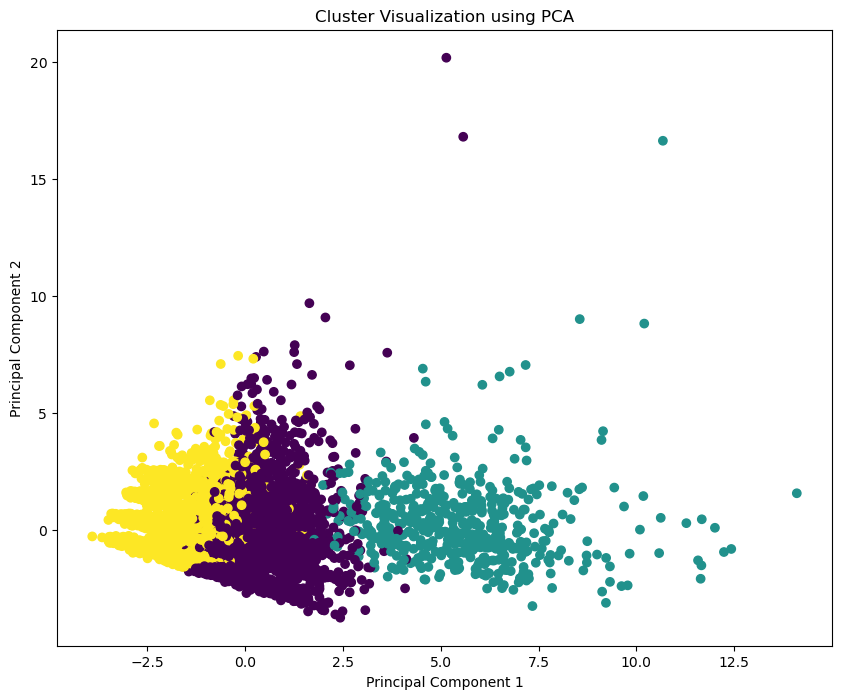

Silhouette Score: 0.14080182258769652


In [14]:
from sklearn.decomposition import PCA

# Perform PCA on the scaled data
pca = PCA(n_components=2)  # You can adjust the number of components as needed
pca_result = pca.fit_transform(data_scaled)

# Plotting the PCA visualization with cluster colors
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization using PCA')
plt.show()

# Calculate silhouette score to validate the clustering quality
silhouette_avg = silhouette_score(data_scaled, kmeans_labels)
print(f"Silhouette Score: {silhouette_avg}")

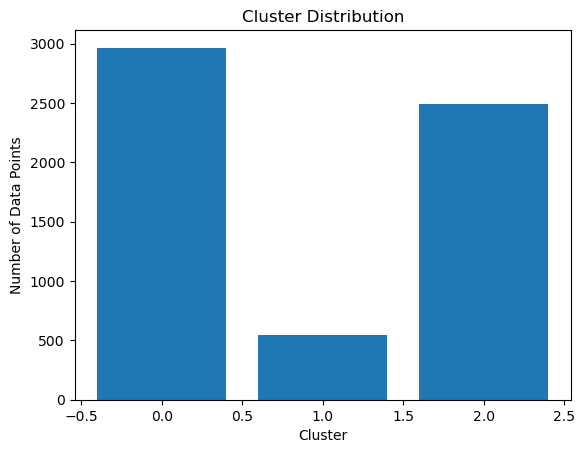

In [15]:
cluster_counts = data_with_kmeans['kmeans_cluster'].value_counts().sort_index()
plt.bar(cluster_counts.index, cluster_counts.values)
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.title('Cluster Distribution')
plt.show()

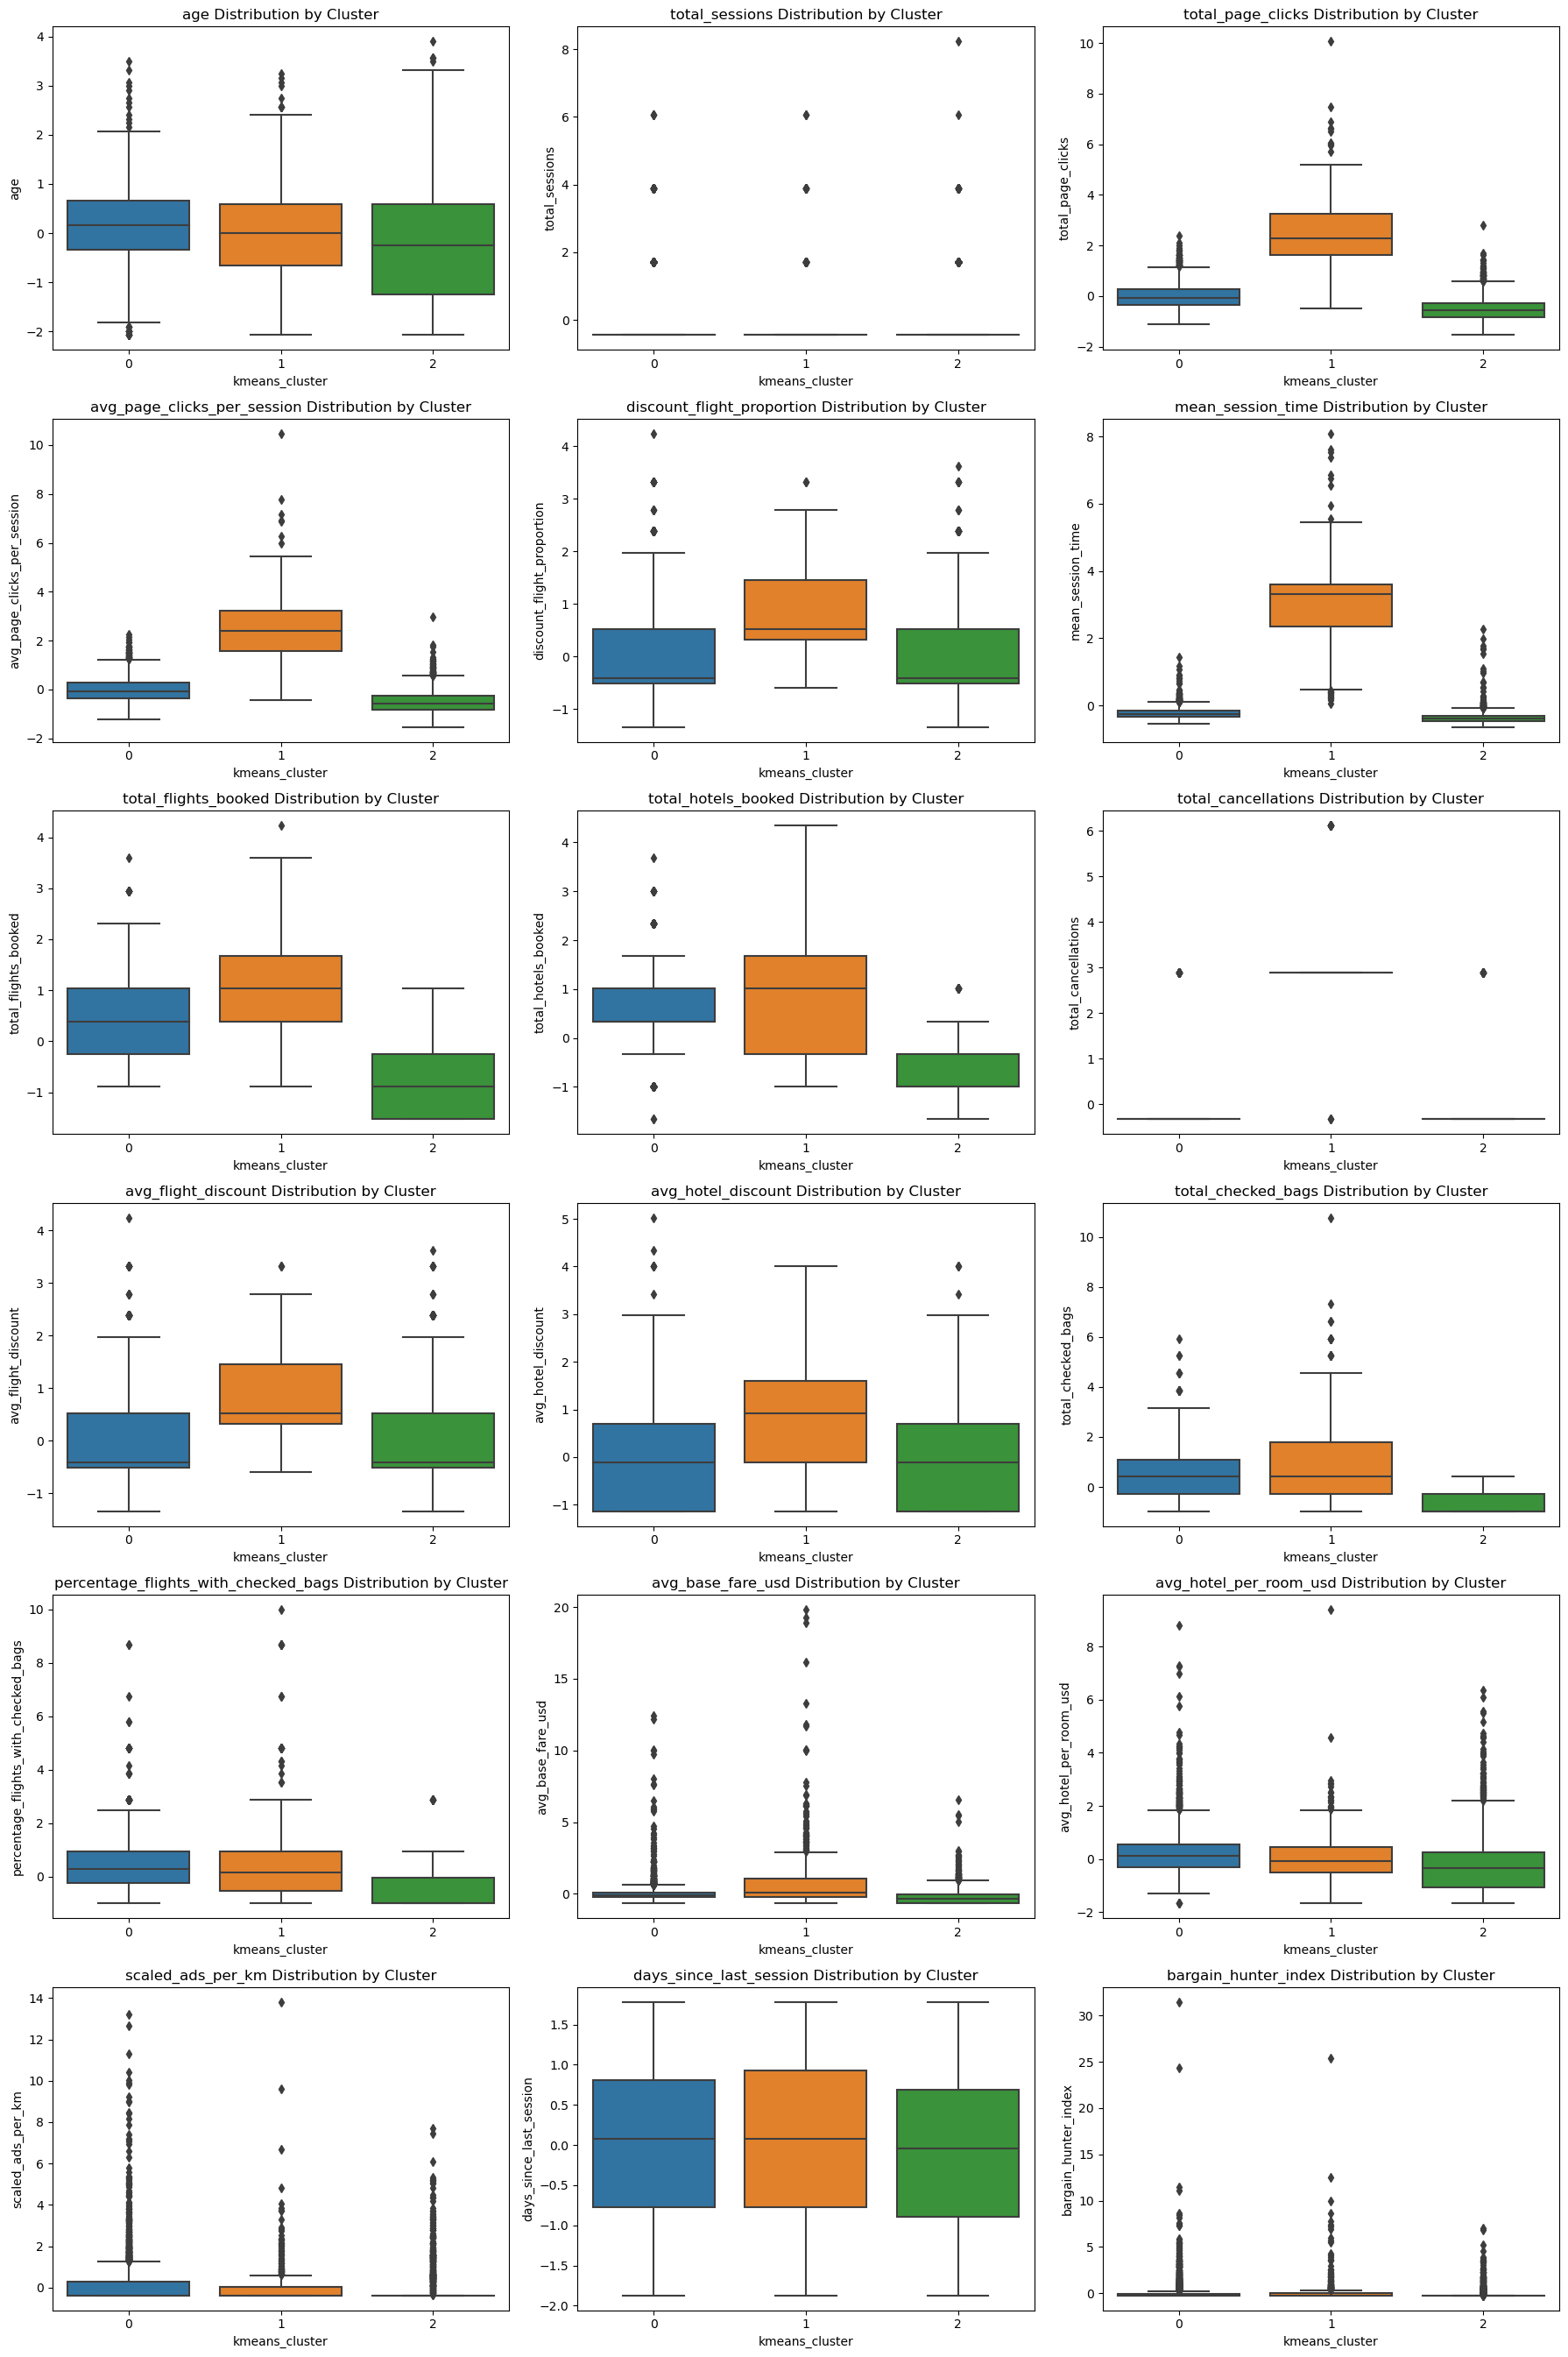

In [16]:
numerical_features = ['age', 'total_sessions', 'total_page_clicks', 'avg_page_clicks_per_session',
                    'discount_flight_proportion', 'mean_session_time', 'total_flights_booked',
                    'total_hotels_booked', 'total_cancellations', 'avg_flight_discount',
                    'avg_hotel_discount', 'total_checked_bags', 'percentage_flights_with_checked_bags',
                    'avg_base_fare_usd', 'avg_hotel_per_room_usd', 'scaled_ads_per_km',
                    'days_since_last_session', 'bargain_hunter_index']

plt.figure(figsize=(18, 27))  # Adjust the figure size as needed
for idx, column in enumerate(numerical_features, 1):  # Use enumerate to get both index and column name
    plt.subplot(6, 3, idx)  # Adjust the number of rows and columns based on your preferences
    sns.boxplot(x='kmeans_cluster', y=column, data=data_with_kmeans)
    plt.title(f'{column} Distribution by Cluster')

plt.tight_layout()
plt.show()

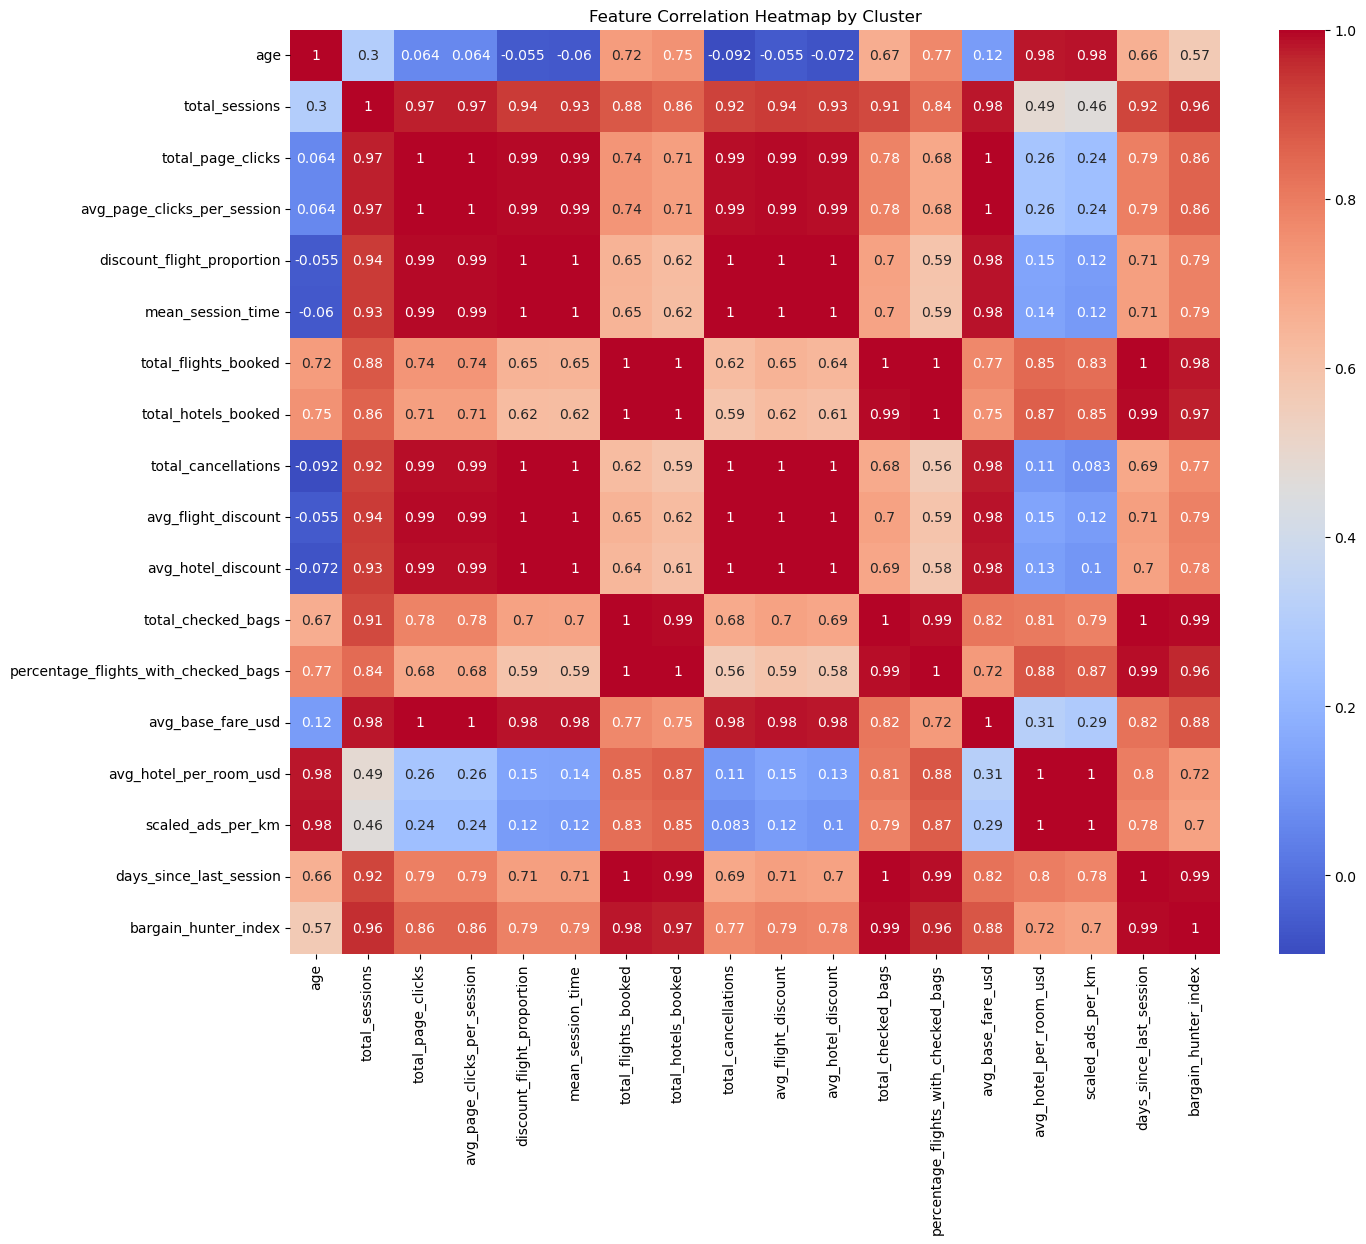

Correlation Matrix:
                                           age  total_sessions  \
age                                   1.000000        0.300949   
total_sessions                        0.300949        1.000000   
total_page_clicks                     0.063729        0.970881   
avg_page_clicks_per_session           0.063579        0.970845   
discount_flight_proportion           -0.055468        0.935479   
mean_session_time                    -0.059954        0.933882   
total_flights_booked                  0.721060        0.877753   
total_hotels_booked                   0.747941        0.858085   
total_cancellations                  -0.092327        0.921782   
avg_flight_discount                  -0.055468        0.935479   
avg_hotel_discount                   -0.072486        0.929317   
total_checked_bags                    0.670937        0.909056   
percentage_flights_with_checked_bags  0.770866        0.839457   
avg_base_fare_usd                     0.117757        0.

In [17]:
cluster_feature_subset = data_with_kmeans[numerical_features + ['kmeans_cluster']]
cluster_means = cluster_feature_subset.groupby('kmeans_cluster').mean()
correlation_matrix = cluster_means.corr()

# Plot the heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap by Cluster')
plt.show()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

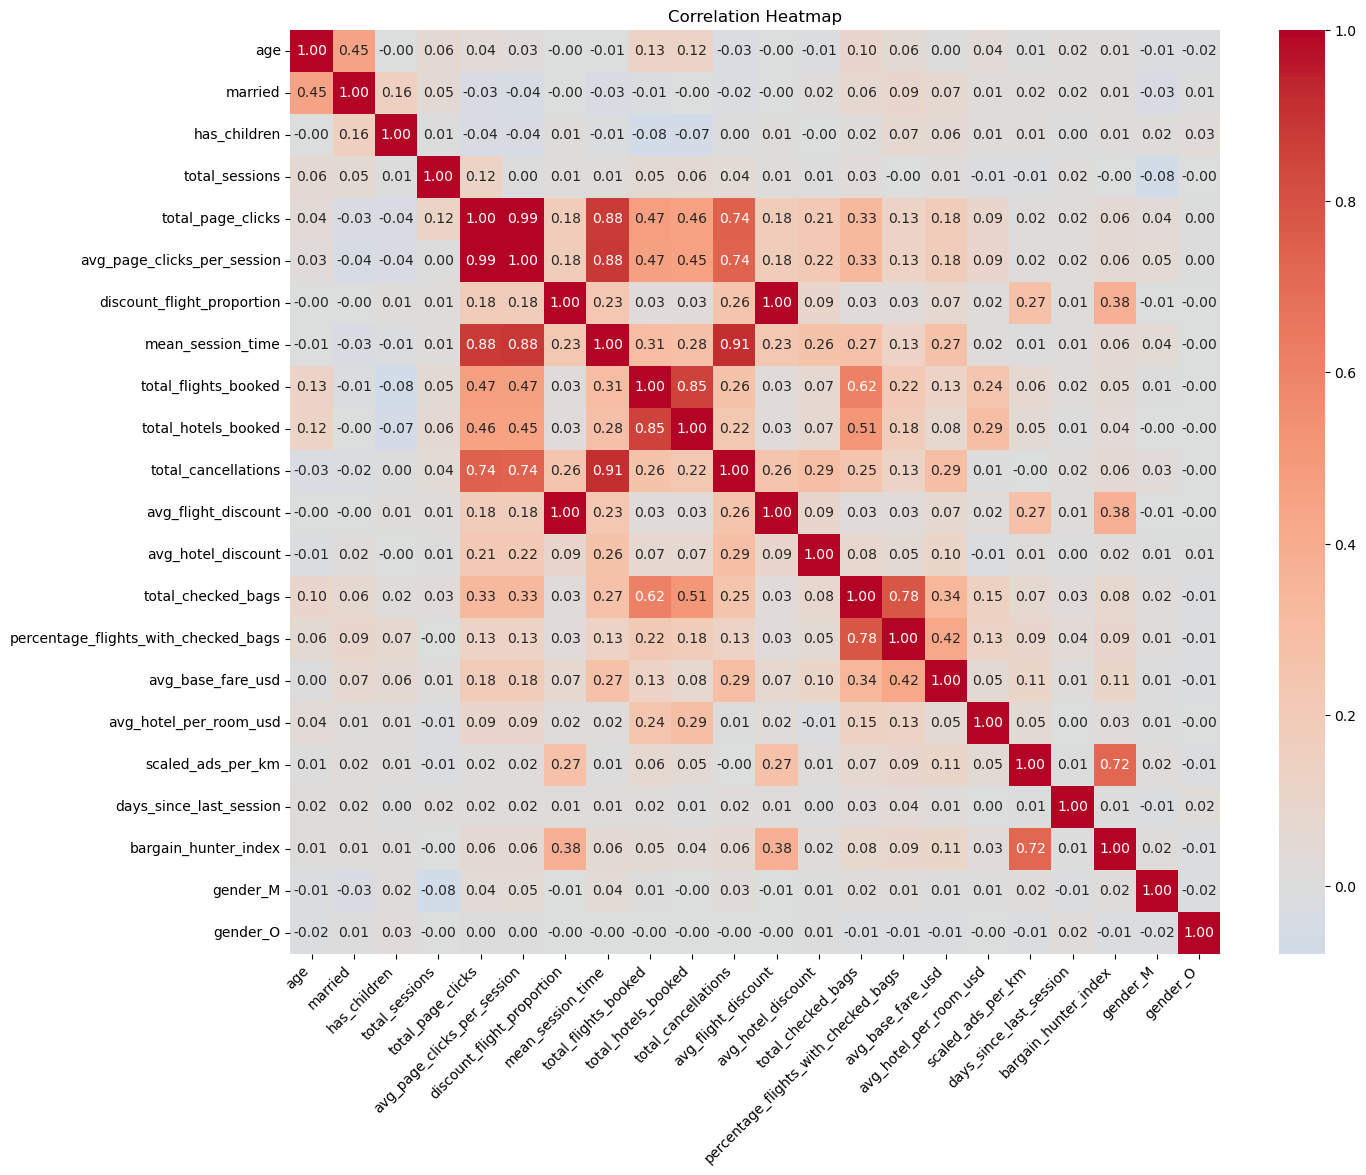

Correlation Matrix:
                                           age   married  has_children  \
age                                   1.000000  0.445254     -0.000994   
married                               0.445254  1.000000      0.158666   
has_children                         -0.000994  0.158666      1.000000   
total_sessions                        0.057432  0.050666      0.006523   
total_page_clicks                     0.038272 -0.033910     -0.035450   
avg_page_clicks_per_session           0.031749 -0.039636     -0.036457   
discount_flight_proportion           -0.001929 -0.000927      0.014635   
mean_session_time                    -0.007205 -0.030334     -0.012940   
total_flights_booked                  0.131542 -0.012177     -0.079077   
total_hotels_booked                   0.122397 -0.004823     -0.070267   
total_cancellations                  -0.028134 -0.018060      0.003288   
avg_flight_discount                  -0.001929 -0.000927      0.014635   
avg_hotel_discount

In [18]:
# Convert 'gender' column to numerical using one-hot encoding
data_encoded = pd.get_dummies(data, columns=['gender'], drop_first=True)

# Remove 'user_id' column
data_encoded = data_encoded.drop(columns=['user_id'])

# Calculate the correlation matrix
correlation_matrix = data_encoded.corr()

# Create a larger heatmap of the correlation matrix with annotated values
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45, ha="right")
plt.show()
print("Correlation Matrix:")
print(correlation_matrix)

The first visualization focuses on how features within the same cluster correlate with each other, providing insights into the within-cluster relationships. It's more targeted to the context of the clusters.
The second visualization provides a broader view of correlations across all features, which might be useful for understanding relationships between features in a broader context.
So, the results would not be mathematically identical due to the different datasets (cluster means vs. full dataset) and the specific focus of each visualization. It's important to choose the visualization that aligns with your analytical goals.

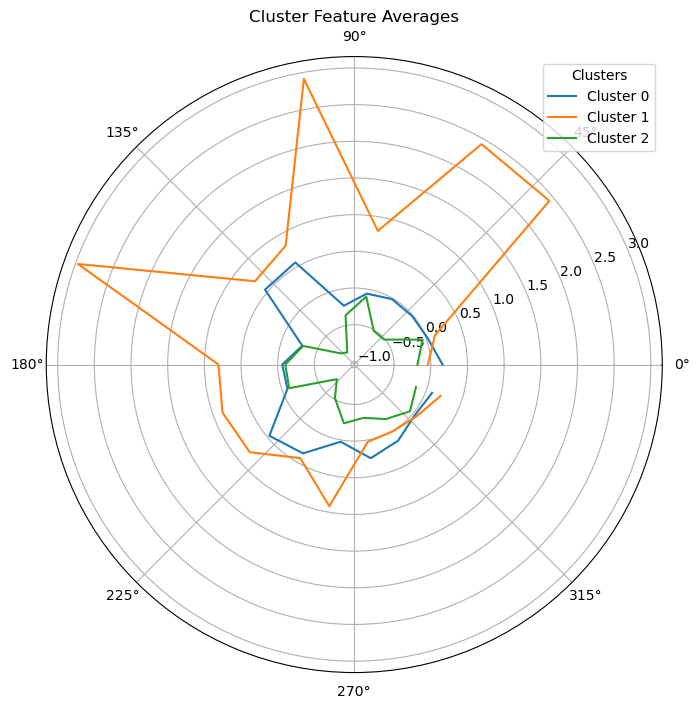

In [19]:
plt.figure(figsize=(10, 8))
for cluster in range(n_clusters):
    cluster_data = data_with_kmeans[data_with_kmeans['kmeans_cluster'] == cluster]
    cluster_avg = cluster_data[numerical_features].mean()
    plt.polar(np.linspace(0, 2*np.pi, len(numerical_features), endpoint=False), cluster_avg, label=f'Cluster {cluster}')
    
plt.title('Cluster Feature Averages')
plt.legend(title='Clusters', loc='upper right')
plt.show()

In [20]:
data_with_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   5998 non-null   float64
 1   total_sessions                        5998 non-null   float64
 2   total_page_clicks                     5998 non-null   float64
 3   avg_page_clicks_per_session           5998 non-null   float64
 4   discount_flight_proportion            5998 non-null   float64
 5   mean_session_time                     5998 non-null   float64
 6   total_flights_booked                  5998 non-null   float64
 7   total_hotels_booked                   5998 non-null   float64
 8   total_cancellations                   5998 non-null   float64
 9   avg_flight_discount                   5998 non-null   float64
 10  avg_hotel_discount                    5998 non-null   float64
 11  total_checked_bag

In [21]:
# Check for missing values in the dataset
missing_values = data.isnull().sum()

# Display columns with missing values and their counts
print(missing_values[missing_values > 0])

Series([], dtype: int64)


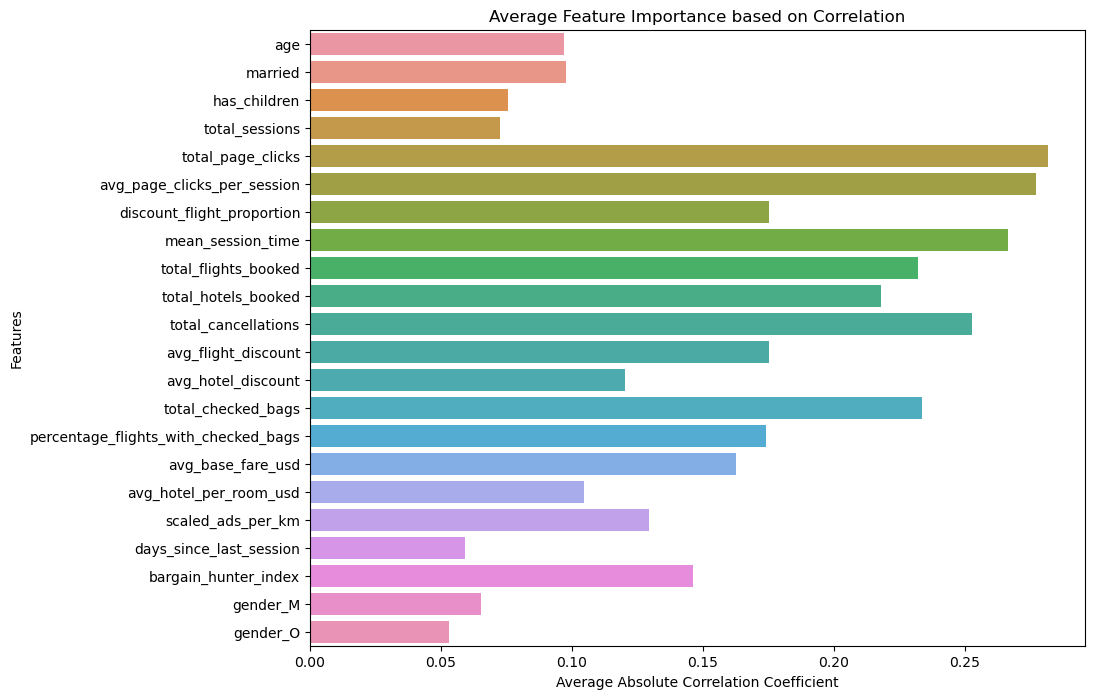

In [22]:
# Calculate the average absolute correlation for each feature
average_correlation = correlation_matrix.abs().mean()

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x=average_correlation.values, y=average_correlation.index)
plt.xlabel('Average Absolute Correlation Coefficient')
plt.ylabel('Features')
plt.title('Average Feature Importance based on Correlation')
plt.show()

In [23]:
average_correlation

age                                     0.096929
married                                 0.097744
has_children                            0.075799
total_sessions                          0.072600
total_page_clicks                       0.281929
avg_page_clicks_per_session             0.277216
discount_flight_proportion              0.175138
mean_session_time                       0.266432
total_flights_booked                    0.232164
total_hotels_booked                     0.218056
total_cancellations                     0.252730
avg_flight_discount                     0.175138
avg_hotel_discount                      0.120446
total_checked_bags                      0.233687
percentage_flights_with_checked_bags    0.174006
avg_base_fare_usd                       0.162890
avg_hotel_per_room_usd                  0.104744
scaled_ads_per_km                       0.129321
days_since_last_session                 0.059372
bargain_hunter_index                    0.146182
gender_M            

In [24]:
data_with_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 20 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   5998 non-null   float64
 1   total_sessions                        5998 non-null   float64
 2   total_page_clicks                     5998 non-null   float64
 3   avg_page_clicks_per_session           5998 non-null   float64
 4   discount_flight_proportion            5998 non-null   float64
 5   mean_session_time                     5998 non-null   float64
 6   total_flights_booked                  5998 non-null   float64
 7   total_hotels_booked                   5998 non-null   float64
 8   total_cancellations                   5998 non-null   float64
 9   avg_flight_discount                   5998 non-null   float64
 10  avg_hotel_discount                    5998 non-null   float64
 11  total_checked_bag

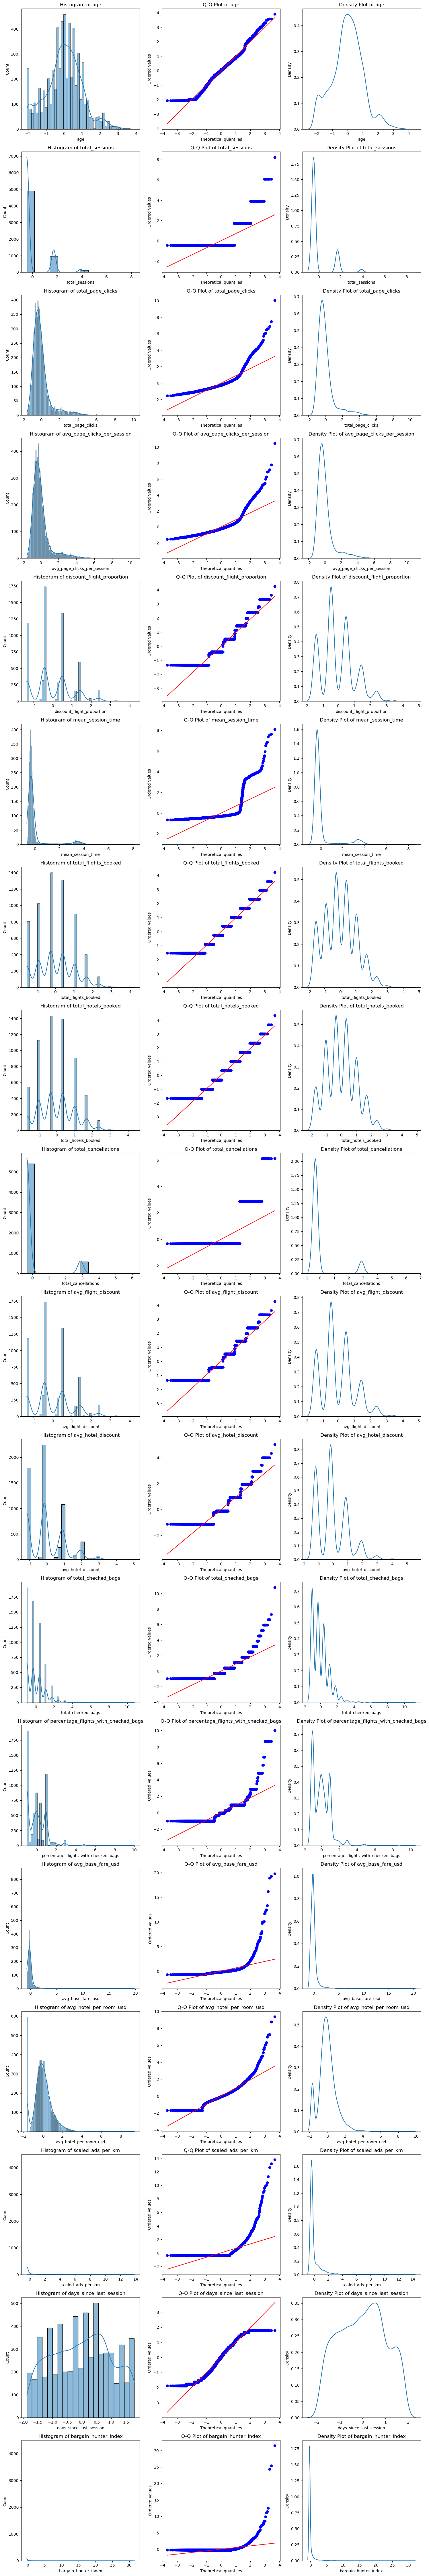

In [25]:
# Select all numerical columns for histograms, Q-Q plots, and density plots
numerical_columns = data_with_kmeans.select_dtypes(include=['float64']).columns

# Create subplots
num_cols = len(numerical_columns)
fig, axes = plt.subplots(num_cols, 3, figsize=(15, 5*num_cols))

for i, column in enumerate(numerical_columns):
    # Histogram with KDE
    sns.histplot(data_with_kmeans[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')
    
    # Q-Q Plot
    stats.probplot(data_with_kmeans[column], plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot of {column}')
    
    # Density Plot
    sns.kdeplot(data_with_kmeans[column], ax=axes[i, 2])
    axes[i, 2].set_title(f'Density Plot of {column}')

# Adjust layout
plt.tight_layout()
plt.show()


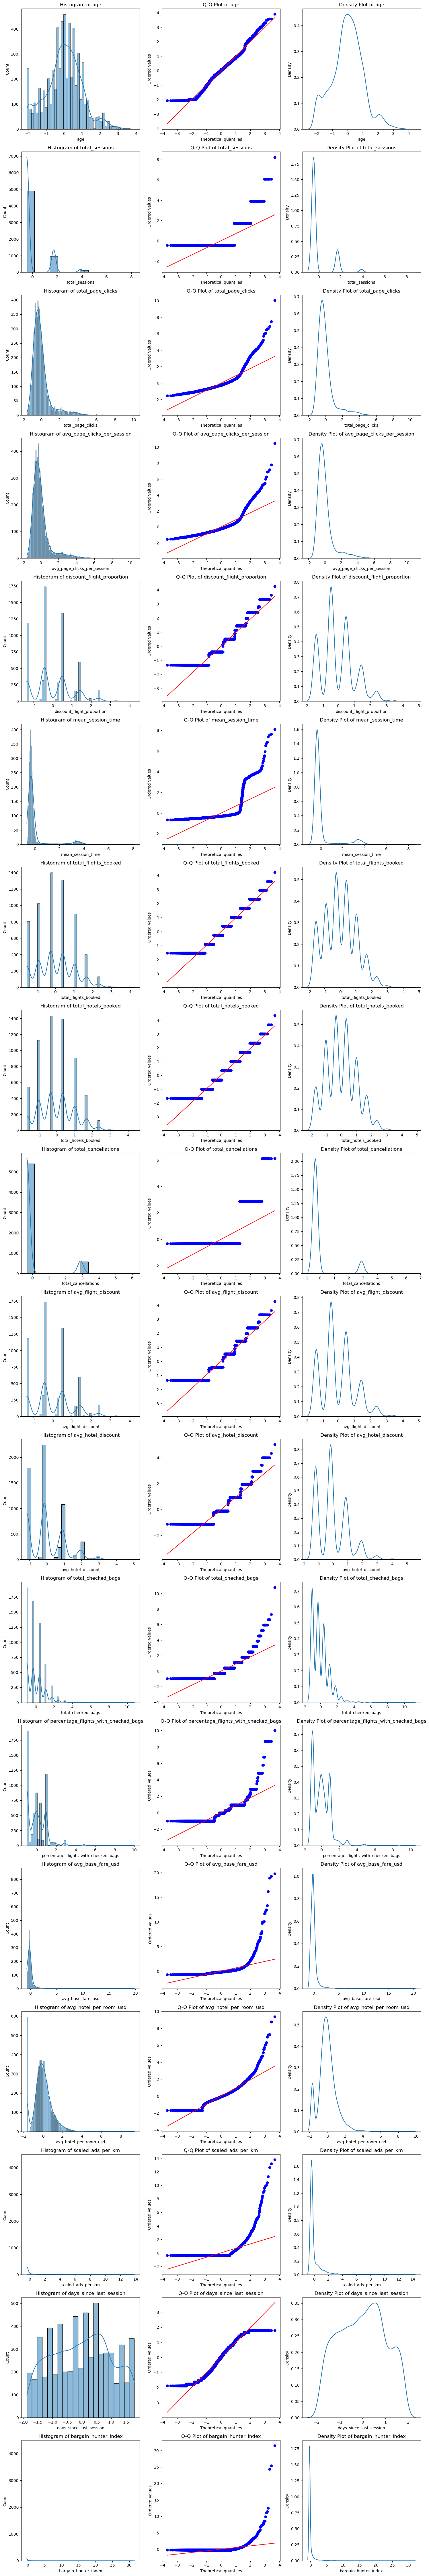

In [26]:
# Select all numerical columns for histograms, Q-Q plots, and density plots
numerical_columns = data_with_kmeans.select_dtypes(include=['float64']).columns

# Create subplots
num_cols = len(numerical_columns)
fig, axes = plt.subplots(num_cols, 3, figsize=(15, 5*num_cols))

for i, column in enumerate(numerical_columns):
    # Histogram with KDE
    sns.histplot(data_with_kmeans[column], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f'Histogram of {column}')
    
    # Q-Q Plot
    stats.probplot(data_with_kmeans[column], plot=axes[i, 1])
    axes[i, 1].set_title(f'Q-Q Plot of {column}')
    
    # Density Plot
    sns.kdeplot(data_with_kmeans[column], ax=axes[i, 2])
    axes[i, 2].set_title(f'Density Plot of {column}')

# Adjust layout
plt.tight_layout()
plt.show()


In [27]:
data['segment'] = data_with_kmeans['segment']
data['kmeans_cluster'] = data_with_kmeans['kmeans_cluster']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5998 entries, 0 to 5997
Data columns (total 24 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   user_id                               5998 non-null   int64  
 1   age                                   5998 non-null   int64  
 2   gender                                5998 non-null   object 
 3   married                               5998 non-null   int64  
 4   has_children                          5998 non-null   int64  
 5   total_sessions                        5998 non-null   int64  
 6   total_page_clicks                     5998 non-null   int64  
 7   avg_page_clicks_per_session           5998 non-null   float64
 8   discount_flight_proportion            5998 non-null   float64
 9   mean_session_time                     5998 non-null   float64
 10  total_flights_booked                  5998 non-null   int64  
 11  total_hotels_book

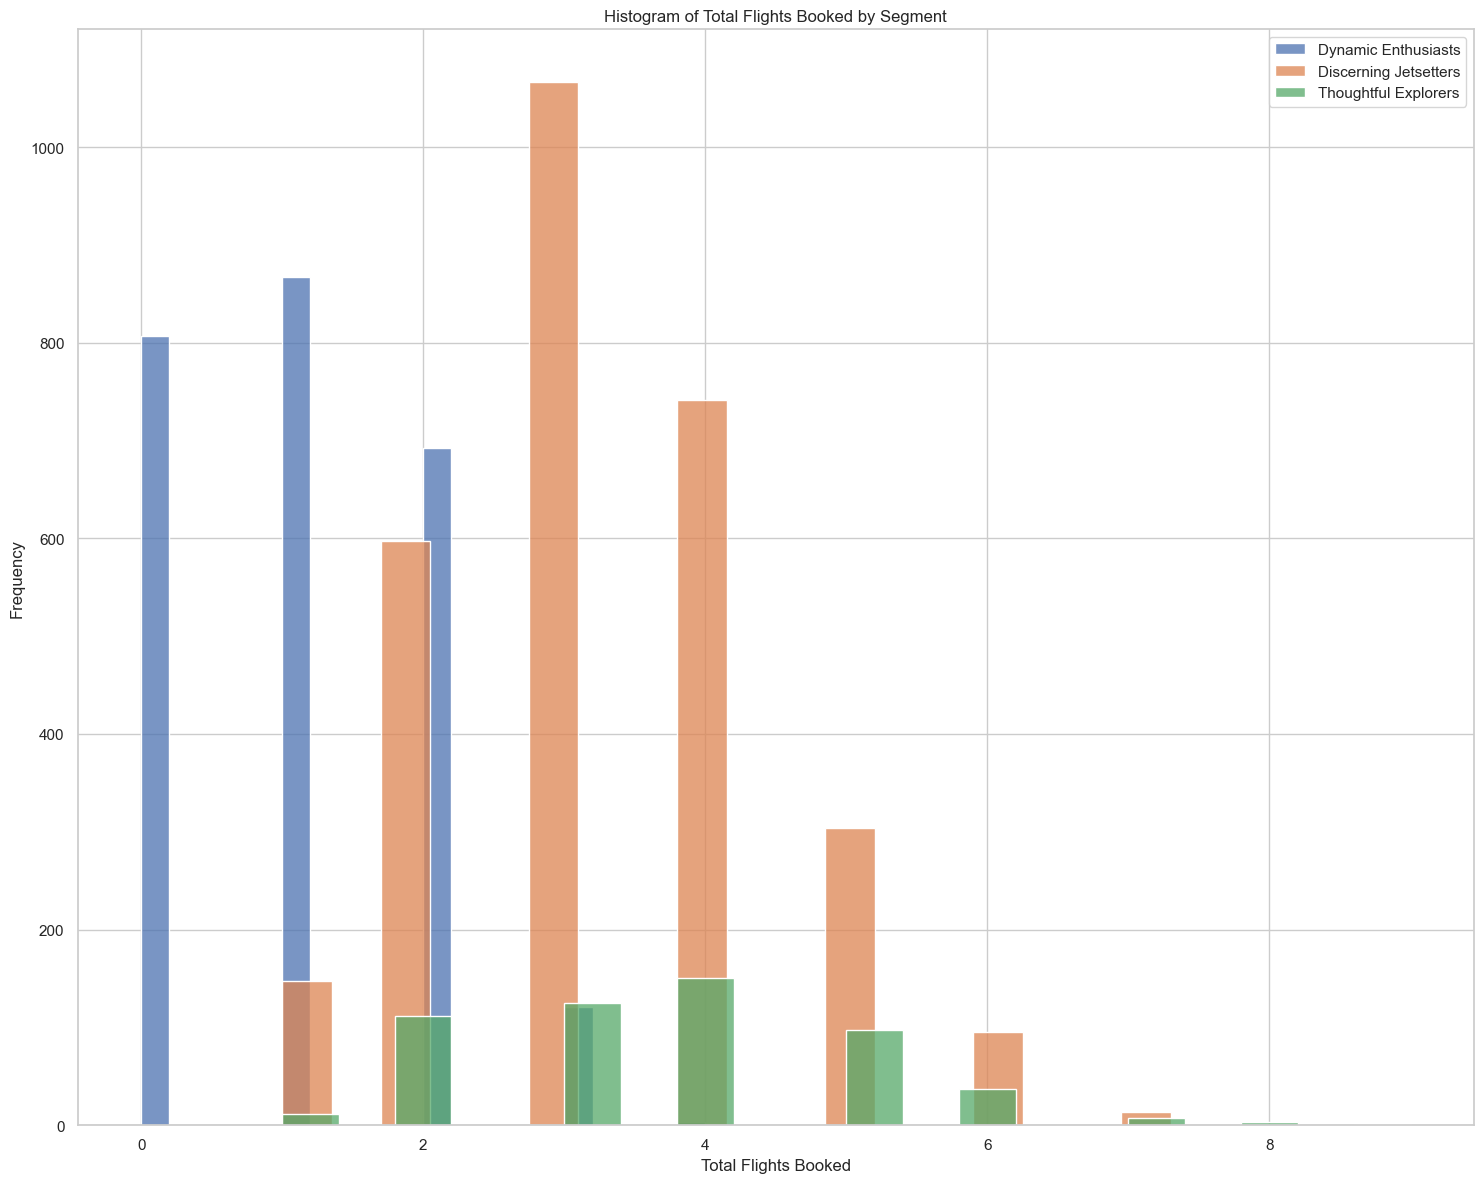

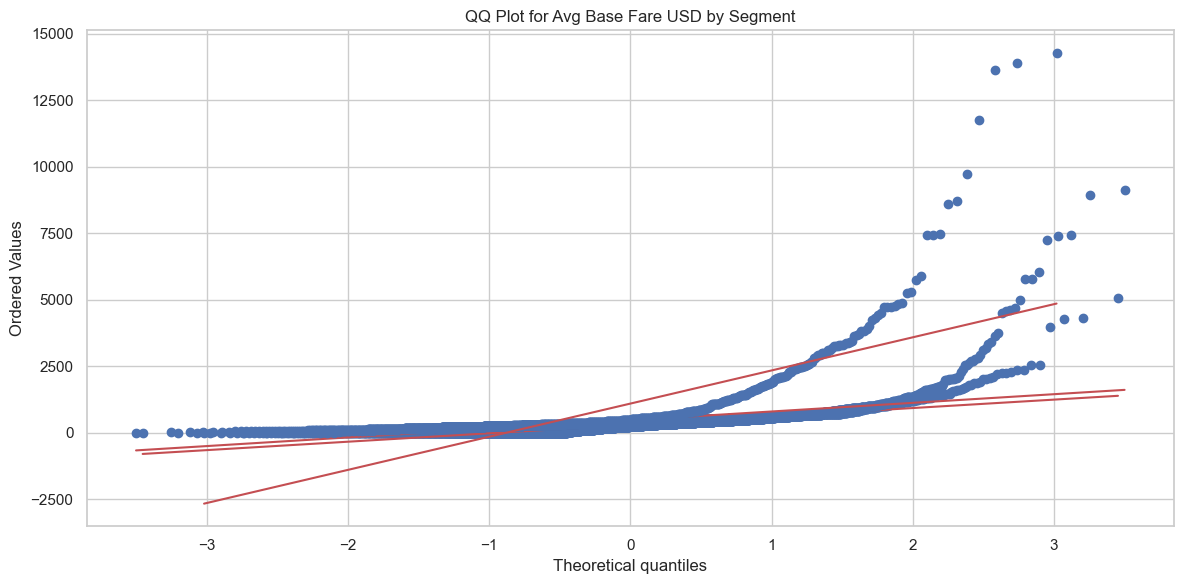

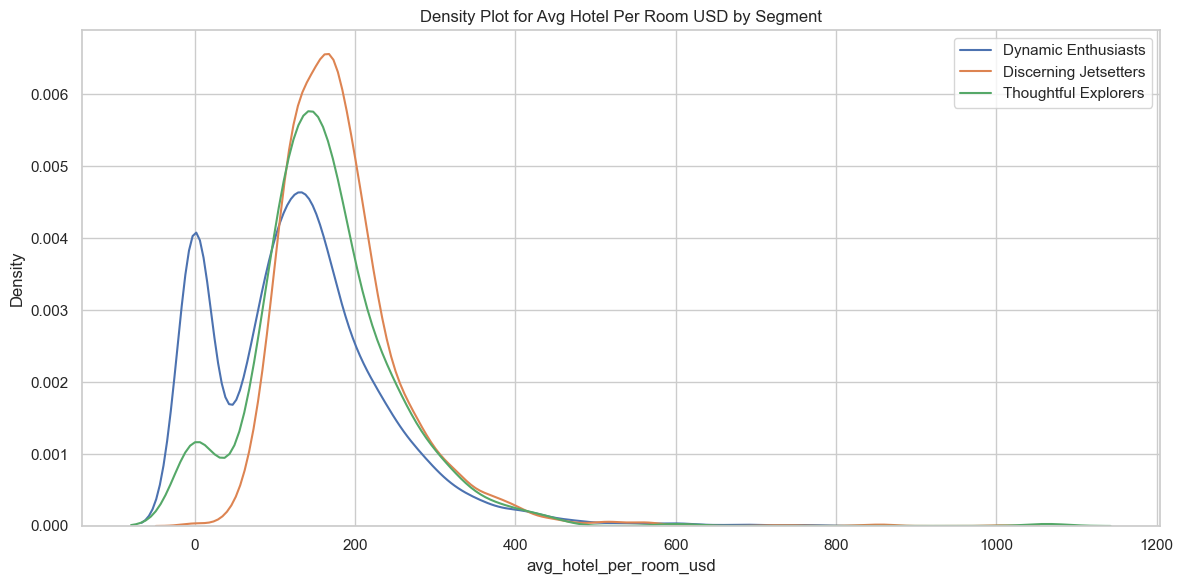

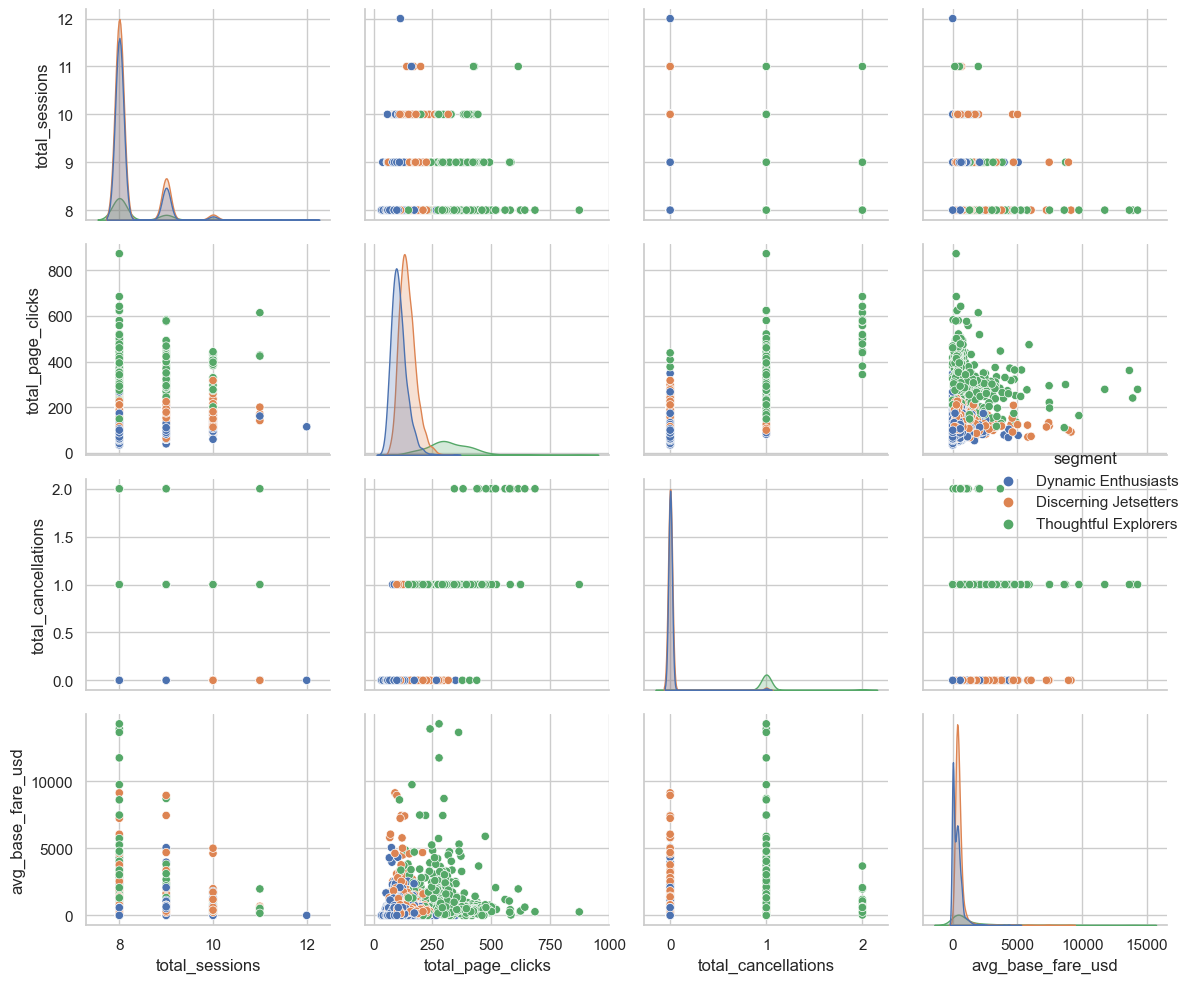

In [28]:
# Set the style of the visualizations
sns.set(style="whitegrid")

# Histograms by Segment
plt.figure(figsize=(15, 12))
for segment in data['segment'].unique():
    sns.histplot(data[data['segment'] == segment]['total_flights_booked'], bins=20, label=segment, kde=False)
plt.xlabel('Total Flights Booked')
plt.ylabel('Frequency')
plt.title('Histogram of Total Flights Booked by Segment')
plt.legend()
plt.tight_layout()
plt.show()

# QQ Plot by Segment
plt.figure(figsize=(12, 6))
for segment in data['segment'].unique():
    stats.probplot(data[data['segment'] == segment]['avg_base_fare_usd'], plot=plt)
plt.title('QQ Plot for Avg Base Fare USD by Segment')
plt.tight_layout()
plt.show()

# Density Plot by Segment
plt.figure(figsize=(12, 6))
for segment in data['segment'].unique():
    sns.kdeplot(data[data['segment'] == segment]['avg_hotel_per_room_usd'], label=segment)
plt.title('Density Plot for Avg Hotel Per Room USD by Segment')
plt.legend()
plt.tight_layout()
plt.show()

# Pair Plot by Segment
sns.pairplot(data, hue='segment', vars=['total_sessions', 'total_page_clicks', 'total_cancellations', 'avg_base_fare_usd'])
plt.tight_layout()
plt.show()

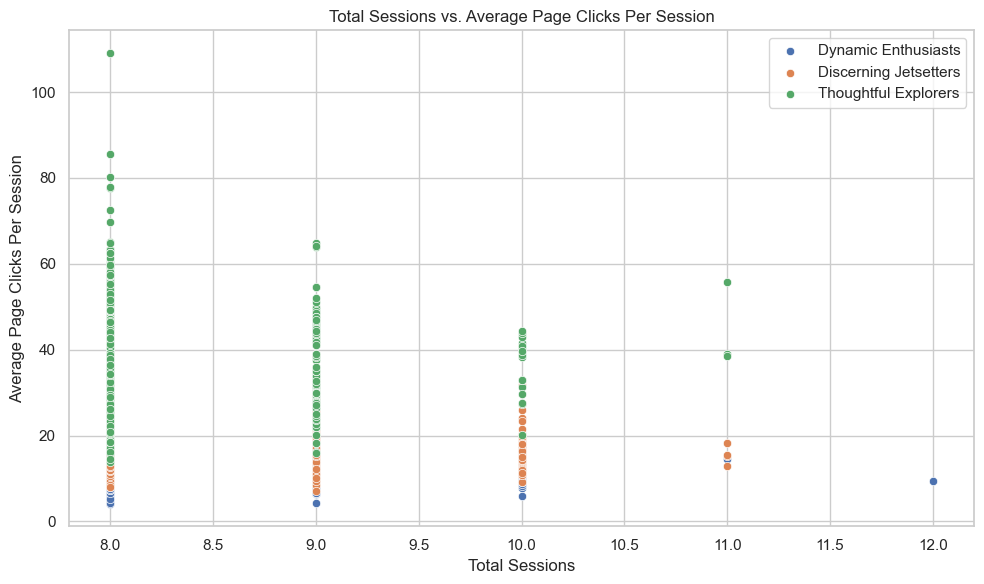

Correlation Coefficient for Total Sessions vs. Average Page Clicks Per Session:
                 segment         level_1  avg_page_clicks_per_session
0  Discerning Jetsetters  total_sessions                    -0.066221
1    Dynamic Enthusiasts  total_sessions                    -0.041467
2   Thoughtful Explorers  total_sessions                    -0.074426



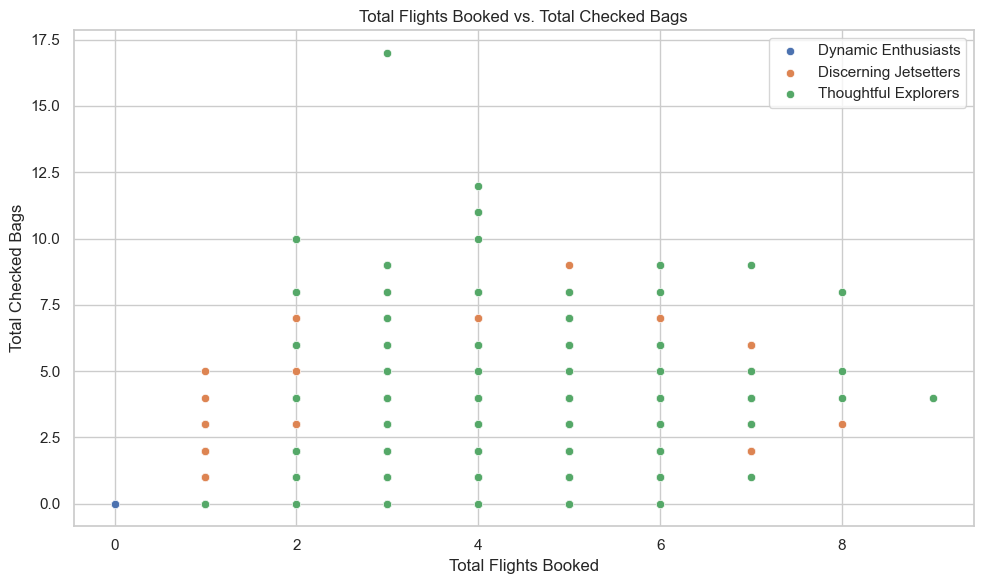

Correlation Coefficient for Total Flights Booked vs. Total Checked Bags:
                 segment               level_1  total_checked_bags
0  Discerning Jetsetters  total_flights_booked            0.319369
1    Dynamic Enthusiasts  total_flights_booked            0.410031
2   Thoughtful Explorers  total_flights_booked            0.266005



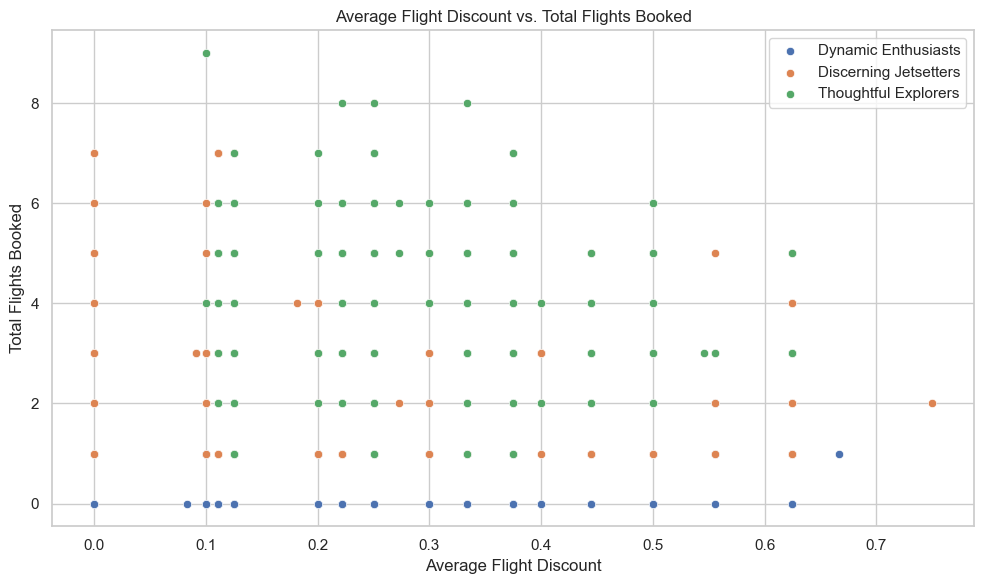

Correlation Coefficient for Average Flight Discount vs. Total Flights Booked:
                 segment              level_1  total_flights_booked
0  Discerning Jetsetters  avg_flight_discount             -0.126947
1    Dynamic Enthusiasts  avg_flight_discount             -0.007711
2   Thoughtful Explorers  avg_flight_discount             -0.045544



In [29]:
# Set the style of the visualizations
sns.set(style="whitegrid")

# Plot 1: Total Sessions vs. Average Page Clicks Per Session
plt.figure(figsize=(10, 6))
for segment in data['segment'].unique():
    sns.scatterplot(data=data[data['segment'] == segment], x='total_sessions', y='avg_page_clicks_per_session', label=segment)
plt.xlabel('Total Sessions')
plt.ylabel('Average Page Clicks Per Session')
plt.title('Total Sessions vs. Average Page Clicks Per Session')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate correlation coefficient for scatter plot 1
correlation_sessions_clicks = data.groupby('segment')[['total_sessions', 'avg_page_clicks_per_session']].corr().iloc[0::2,-1].reset_index()
print("Correlation Coefficient for Total Sessions vs. Average Page Clicks Per Session:")
print(correlation_sessions_clicks)
print()

# Plot 2: Total Flights Booked vs. Total Checked Bags
plt.figure(figsize=(10, 6))
for segment in data['segment'].unique():
    sns.scatterplot(data=data[data['segment'] == segment], x='total_flights_booked', y='total_checked_bags', label=segment)
plt.xlabel('Total Flights Booked')
plt.ylabel('Total Checked Bags')
plt.title('Total Flights Booked vs. Total Checked Bags')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate correlation coefficient for scatter plot 2
correlation_flights_bags = data.groupby('segment')[['total_flights_booked', 'total_checked_bags']].corr().iloc[0::2,-1].reset_index()
print("Correlation Coefficient for Total Flights Booked vs. Total Checked Bags:")
print(correlation_flights_bags)
print()

# Plot 3: Average Flight Discount vs. Total Flights Booked
plt.figure(figsize=(10, 6))
for segment in data['segment'].unique():
    sns.scatterplot(data=data[data['segment'] == segment], x='avg_flight_discount', y='total_flights_booked', label=segment)
plt.xlabel('Average Flight Discount')
plt.ylabel('Total Flights Booked')
plt.title('Average Flight Discount vs. Total Flights Booked')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate correlation coefficient for scatter plot 3
correlation_discount_flights = data.groupby('segment')[['avg_flight_discount', 'total_flights_booked']].corr().iloc[0::2,-1].reset_index()
print("Correlation Coefficient for Average Flight Discount vs. Total Flights Booked:")
print(correlation_discount_flights)
print()

Analysis of Correlation Coefficients:

Total Sessions vs. Average Page Clicks Per Session:
The correlation coefficient between total sessions and average page clicks per session is negative but weak, indicating a slight tendency that as the total sessions increase, the average page clicks per session might decrease slightly.

Total Flights Booked vs. Total Checked Bags:
The correlation coefficient between total flights booked and total checked bags is positive and moderate, suggesting that there is a moderate tendency for passengers who book more flights to have more checked bags.

Average Flight Discount vs. Total Flights Booked:
The correlation coefficient between average flight discount and total flights booked is negative and weak, indicating a slight tendency that as the average flight discount increases, the total number of flights booked might decrease slightly.

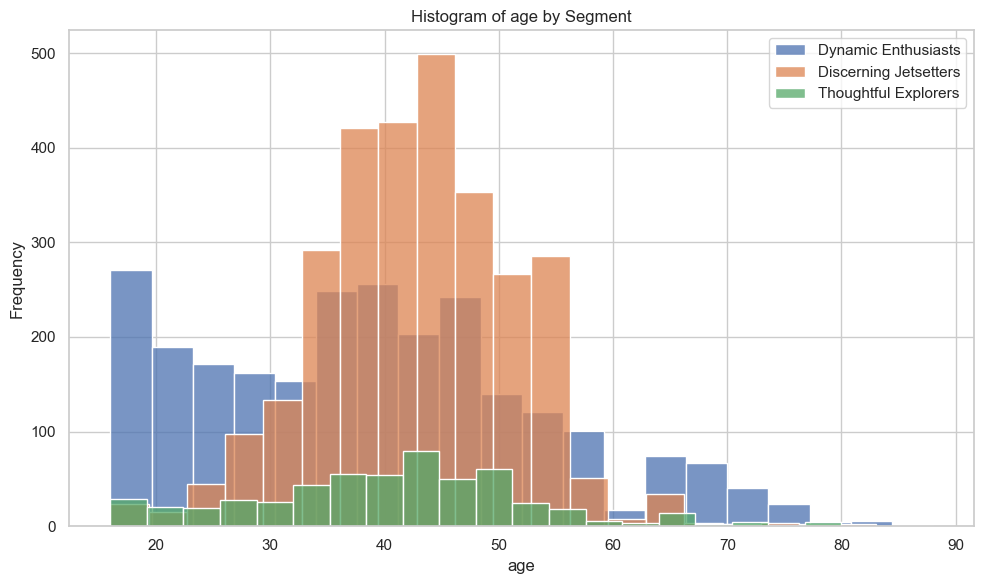

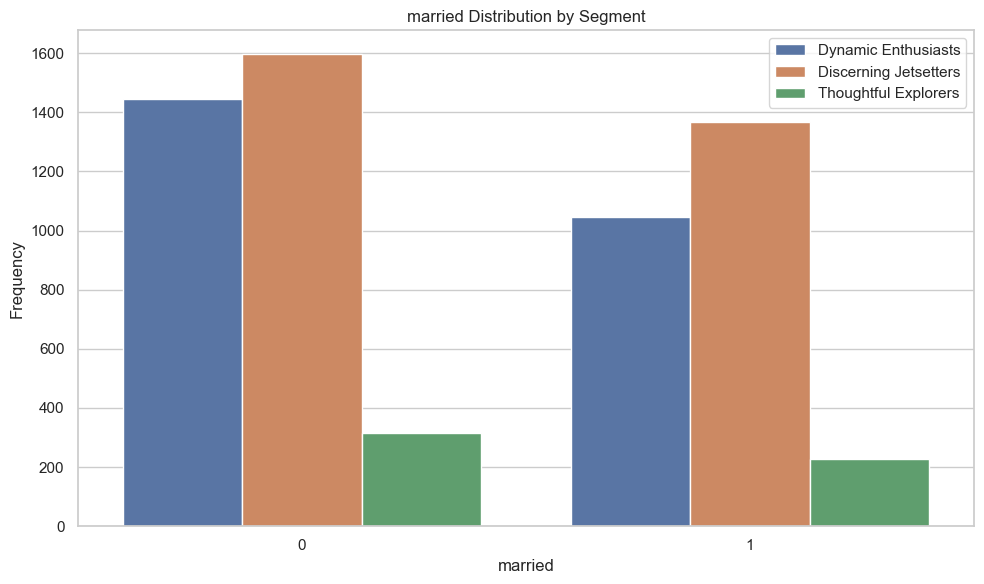

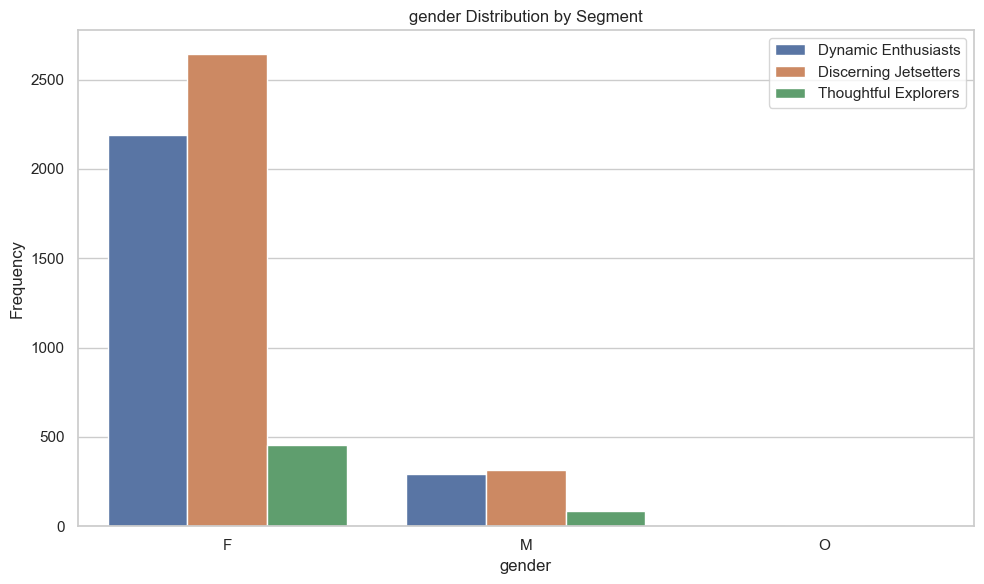

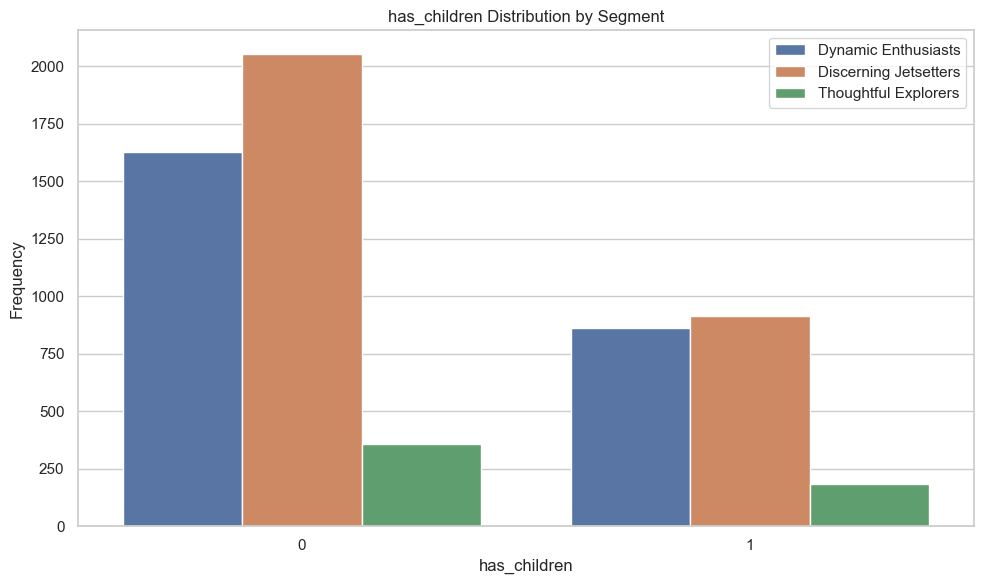

In [30]:
# Function to plot histogram for a specific feature and segment
def plot_histogram(data, feature, segments):
    plt.figure(figsize=(10, 6))
    for segment in segments:
        sns.histplot(data=data[data['segment'] == segment][feature], bins=20, label=segment, kde=False)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature} by Segment')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plotting separate histograms for Age in each segment
plot_histogram(data, 'age', data['segment'].unique())

# Function to plot bar plot for a specific categorical feature across segments
def plot_bar_plot(data, feature):
    plt.figure(figsize=(10, 6))
    sns.countplot(data=data, x=feature, hue='segment')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'{feature} Distribution by Segment')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plotting bar plot for Married Status Distribution
plot_bar_plot(data, 'married')

# Plotting bar plot for Gender Distribution
plot_bar_plot(data, 'gender')

# Plotting bar plot for Has Children Distribution
plot_bar_plot(data, 'has_children')
